In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sympy as sp
from scipy.optimize import least_squares

Text(0, 0.5, 'Signal')

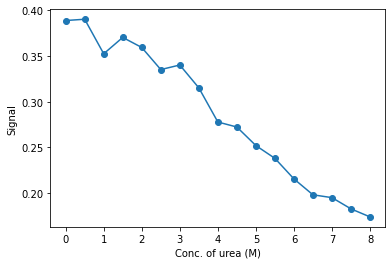

In [20]:
# Data1

C1=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8]
S=[0.3887,0.3901,0.3523,0.3702,0.3592,0.335,0.34,0.315,0.2776,0.2721,0.2518,0.2378,0.2153,0.1979,0.1948,0.1825,0.1737]
plt.plot(C1,S)
plt.scatter(C1,S)
plt.xlabel('Conc. of urea (M)')
plt.ylabel('Signal')

Text(0, 0.5, 'Rate constant (s^(-1)')

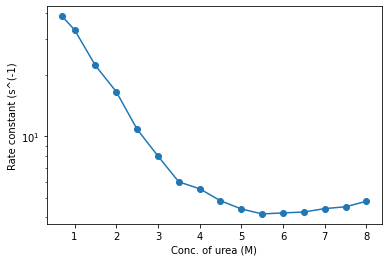

In [21]:
# Data2

C2=[0.7,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8]
K=[38.7229,33.2154,22.2161,16.5351,10.8232,8.0023,5.9774,5.5302,4.8313,4.4056,4.1643,4.2110,4.2548,4.4208,4.5137,4.8018]
plt.semilogy(C2,K)
plt.scatter(C2,K)
plt.xlabel('Conc. of urea (M)')
plt.ylabel('Rate constant (s^(-1)')

# Two-state model C vs S

In [22]:
a_b=np.polyfit(C1[15:17],S[15:17],deg=1)
c_d=np.polyfit(C1[0:2],S[0:2],deg=1)
Su_pred=[a_b@np.asarray((i**1,i**0)) for i in C1]
Sf_pred=[c_d@np.asarray((i**1,i**0)) for i in C1]
#plt.plot(C1,Su_pred)
#plt.plot(C1,Sf_pred)
#plt.plot(C1,S)
a=a_b[1]
b=a_b[0]
c=c_d[1]
d=c_d[0]

In [23]:
def delgfit(T,co,R_val,Para):
    m=Para[0]
    del_G_w=Para[1]
    a1=Para[2]
    b1=Para[3]
    c1=Para[4]
    d1=Para[5]
    dg=del_G_w - m*co
    #del_G.append(dg)
    k_eq=math.exp(-dg/R_val/T)
    Pf=1/(1+k_eq)
    Su= a1 + b1*(co-1)
    Sf= c1 + d1*(co-1)
    S_pr=Sf*Pf + Su*(1-Pf)
    return S_pr


def errorfun(Para,C1,S):
    
    T=285 # T units - K
    R_val=8.314e-3 # R units - kJ/mol.K
    S_prd=[]
    for i in range(0,len(C1)):
        co=C1[i]
        S_prd.append(delgfit(T,co,R_val,Para))
    
    S_pred=np.asarray(S_prd)
    #plt.plot(C1,S_pred)
    #plt.scatter(C1,S)
    #print(np.sum((S-S_pred)**2))
    #print(S_pred)
    return ((S-S_pred)).flatten()


#initial condition
P_init=[4,7,a,0,c,0]

#LSQ curve fit
out=least_squares(errorfun,P_init,args=(C1,S),bounds=((-np.inf,-np.inf,0.2,-0.019,0.385,-0.008),(np.inf,np.inf,np.inf,0,np.inf,0)))

# Optimized parameters fit
m=out.x[0]
del_G_w=out.x[1]
a_fin=out.x[2]
b_fin=out.x[3]
c_fin=out.x[4]
d_fin=out.x[5]
C_m=del_G_w/m
print('del_G_w_ref =' , del_G_w , 'kJ/mol ; m =' , m , 'kJ/mol.M ; C_m =' , C_m,  'M ; a =' , a_fin,  ' ; b =' , b_fin ,  'M^(-1) ; c =' , c_fin , '; d =' , d_fin , 'M^(-1)')


del_G_w_ref = 8.160490690934957 kJ/mol ; m = 1.8535266535706851 kJ/mol.M ; C_m = 4.402683217537962 M ; a = 0.2122365132536583  ; b = -0.006764686160970963 M^(-1) ; c = 0.38500000000057255 ; d = -0.007179209880223537 M^(-1)


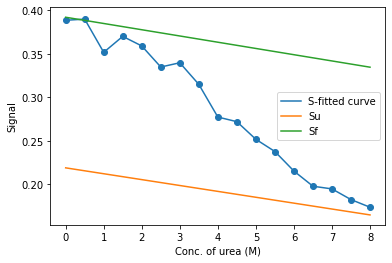

In [24]:
# Fitting of data, folding and unfolding curve

S_pred_fin=[i - j**2 for i,j in zip(S,out.fun)]

plt.scatter(C1,S)
plt.plot(C1,S_pred_fin, label='S-fitted curve')

Su_fin=[]
Sf_fin=[]
for i in range(0,len(C1)):
    Su_fin.append(a_fin + b_fin*(C1[i]-1))
    Sf_fin.append(c_fin + d_fin*(C1[i]-1))


plt.plot(C1,Su_fin,label='Su')
plt.plot(C1,Sf_fin,label='Sf')
plt.xlabel('Conc. of urea (M)')
plt.ylabel('Signal')
plt.legend()

# C vs rate constant

In [25]:
def Kfit(co,Para1):
    m_f=Para1[0]
    ln_k_f_ref=Para1[1]
    m_u=Para1[2]
    ln_k_u_ref=Para1[3]
    
        
    ln_k_f=ln_k_f_ref - m_f*co
    ln_k_u=ln_k_u_ref + m_u*co
    
    k_f=math.exp(ln_k_f)
    k_u=math.exp(ln_k_u)
    
    K_pr=k_f + k_u
    
    return K_pr


def errorfun2(Para1,C2,K):    
    K_prd=[]
    ln_K_prd=[]
    ln_K_in=[]
    for i in range(0,len(C2)):
        co=C2[i]
        ln_K_prd.append(math.log(Kfit(co,Para1)))
        ln_K_in.append(math.log(K[i]))
        K_prd.append(Kfit(co,Para1))
    
    ln_K=np.asarray(ln_K_in)
    ln_K_pred=np.asarray(ln_K_prd)
    K_pred=np.asarray(K_prd)
    #plt.semilogy(C2,K_pred)
    #plt.scatter(C2,K)
    #print(np.sum(K-K_pred)**2)
    #print(K_pred)
    return ((ln_K-ln_K_pred)).flatten()

#initial condition
ln_ku_ini=math.log(2)
ln_kf_ini=math.log(100)
P1_init=[0.5,ln_kf_ini,0.2,ln_ku_ini]

#LSQ curve fir
out1=least_squares(errorfun2,P1_init,args=(C2,K))

#optimized parameters
m_f=out1.x[0]
ln_k_f_ref=out1.x[1]
m_u=out1.x[2]
ln_k_u_ref=out1.x[3]

#C_m value
C_m=((ln_k_f_ref)-(ln_k_u_ref))/(m_f+m_u)

print('m_f =' , m_f , 'M^(-1) ; k_f_ref =' , math.exp(ln_k_f_ref) , 's^(-1) ; m_u =' , m_u,  'M^(-1) ; k_u_ref =' , math.exp(ln_k_u_ref),  's^(-1) ;  C_m =' , C_m, 'M' )

# K vs K(predicted)
K_pred=[(math.exp(math.log(i) - (j))) for i,j in zip(K,out1.fun)]
#plt.semilogy(C2,K_pred)
#plt.scatter(C2,K)

m_f = 0.8455860075867151 M^(-1) ; k_f_ref = 70.26240197184 s^(-1) ; m_u = 0.1151460377144868 M^(-1) ; k_u_ref = 1.876703948644197 s^(-1) ;  C_m = 3.7707910665895032 M


Text(0, 0.5, 'Rate constant (s^(-1))')

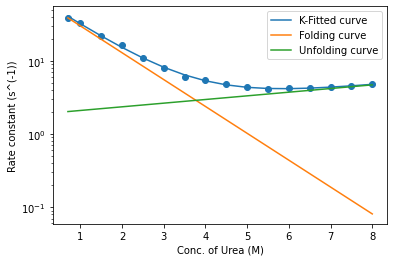

In [26]:
# Chevron plot

kf_fin=[]
ku_fin=[]
for i in range(0,len(C2)):
    ln_kf_fin = (ln_k_f_ref) - m_f*C2[i]
    kf_fin.append(math.exp(ln_kf_fin))
    ln_ku_fin = (ln_k_u_ref) + m_u*C2[i]
    ku_fin.append(math.exp(ln_ku_fin))



plt.semilogy(C2,K_pred,label='K-Fitted curve')
plt.scatter(C2,K)

plt.semilogy(C2,kf_fin,label='Folding curve')
plt.semilogy(C2,ku_fin,label='Unfolding curve')
plt.legend()
plt.xlabel('Conc. of Urea (M)')
plt.ylabel('Rate constant (s^(-1))')